In [43]:
import pyaudio
import speech_recognition
from time import sleep
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import struct
import math
import time
from IPython.display import display, clear_output
import wave
from playsound import playsound
from scipy.io import wavfile

def get_rms( block ):
    # RMS amplitude is defined as the square root of the 
    # mean over time of the square of the amplitude.
    # so we need to convert this string of bytes into 
    # a string of 16-bit samples...

    # we will get one short out for each 
    # two chars in the string.
    count = len(block)/2
    format = "%dh"%(count)
    shorts = struct.unpack( format, block )

    # iterate over the block.
    sum_squares = 0.0
    for sample in shorts:
        # sample is a signed short in +/- 32768. 
        # normalize it to 1.0
        n = sample * SHORT_NORMALIZE
        sum_squares += n*n

    return math.sqrt( sum_squares / count )

def discover_mic(pa, microphone_name):

    for i in range(pa.get_device_count() ):     
        devinfo = pa.get_device_info_by_index(i)   

        if microphone_name in devinfo["name"]:
                device_index = i
                return device_index
            
def initiate_mic(microphone_name):
    pa = pyaudio.PyAudio()
    device_index = discover_mic(pa, microphone_name)  
    mic = pa.open(format = pyaudio.paInt16,
                channels = CHANNEL,
                rate =  RATE ,
                input = True,
                input_device_index = device_index,
                frames_per_buffer = CHUNK
                )
    
    return mic, pa

def visualize_raw_amplitude(blocks, timestamp):
    
    plt.figure(figsize=(12, 6)) 
    ax = plt.subplot(2,2,1)
    
    start = 0
    for block in blocks:
        count = int(len(block)/2)
        format = "%dh"%(count)
        shorts = struct.unpack(format, block)

        x = np.array([*range(start, start+count, 1)])/(RATE*2)
        start = start + count
        
        plt.plot(x, shorts, color = "blue")
        
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")

def visialize_rms_amplitude(blocks, timestamp):
    
    ax = plt.subplot(2,2,2)
    
    y = []
    x = []
    
    for block in blocks:
        amplitude = get_rms(block)
        y.append(amplitude)
        
    plt.plot(timestamp, y, color="#004225")
    plt.xlabel("Time (seconds)")
    plt.ylabel("RMS Amplitude")
    
def visualize_freq(fs,x):
    
    #plot chanenel 0
    chanenel = 0
    ax = plt.subplot(2,2,3)
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(x[:,chanenel], Fs=fs)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    
    #plot chanenel 1
    chanenel = 1
    ax = plt.subplot(2,2,4)
    powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(x[:,chanenel], Fs=fs)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

def close_mic(mic, pa):
    mic.stop_stream()
    mic.close()
    pa.terminate()

def save_audio(filename, pa, blocks):
    wf = wave.open(filename, 'wb')
    wf.setnchannels(CHANNEL)
    wf.setsampwidth(pa.get_sample_size(pyaudio.paInt16))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(blocks))
    wf.close()
    
def play_audio(filename):
    playsound(filename)

In [37]:
SHORT_NORMALIZE = (1.0/32768.0)
RATE = 44100  
INPUT_BLOCK_TIME = 0.05
CHUNK = int(RATE*INPUT_BLOCK_TIME)
CHANNEL = 2

microphone_name = "3- Andrea PureAudio"
filename = "test.wav"
runtime = 5 #sec

mic, pa = initiate_mic(microphone_name)

blocks = []
timestamp = []

st = time.time()

print("Recording starts..")
while True:
    block = mic.read(CHUNK)
    blocks.append(block)
    
    t = time.time() - st
    timestamp.append(t)
    
    if t>runtime:        
        save_audio(filename, pa, blocks)
        break

print("Recording ends..")

Recording starts..
Recording ends..


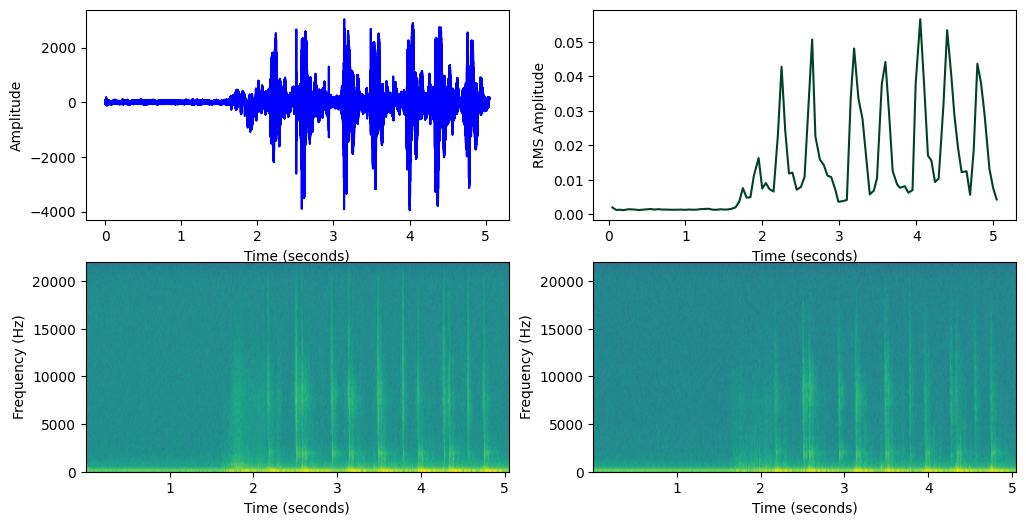

In [44]:
visualize_raw_amplitude(blocks, timestamp)
visialize_rms_amplitude(blocks, timestamp)
fs, x = wavfile.read(filename)
visualize_freq(fs,x)
#playsound(filename)